In [1]:
import numpy as np
import numpy.fft as fft
from astropy.io import fits
import matplotlib.pyplot as plt
import galsim

In [2]:
img1 = fits.open('psf2asec-96.psf.fits')[0].data[0,0,:,:]
img2 = fits.open('psf5asec-96.psf.fits')[0].data[0,0,:,:]
print(img1.shape)
print(img2.shape)

(96, 96)
(96, 96)


### PSF

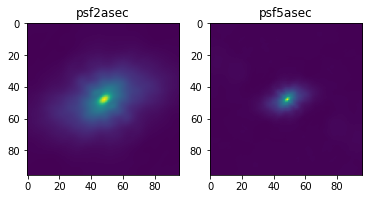

In [3]:
plt.subplot(1,2,1)
plt.imshow(img1)
plt.title('psf2asec')

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title('psf5asec')
plt.show()

### Centered FFT of PSF

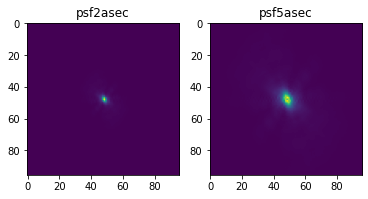

In [4]:
img1_fft = np.abs(fft.fftshift(fft.fft2(img1)))
img2_fft = np.abs(fft.fftshift(fft.fft2(img2)))

plt.subplot(1,2,1)
plt.imshow(img1_fft)
plt.title('psf2asec')

plt.subplot(1,2,2)
plt.imshow(img2_fft)
plt.title('psf5asec')
plt.show()

# Convolution of a Gaussian Galaxy & PSF using Galsim functions

In [5]:
gal_flux = 1.e5    # total counts on the image
gal_sigma = 2.     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 30.        # standard deviation of the counts in each pixel

In [6]:
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma)
psf = galsim.Gaussian(flux=1., sigma=2.)

gal, psf

(galsim.Gaussian(sigma=2.0, flux=100000.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)),
 galsim.Gaussian(sigma=2.0, flux=1.0, gsparams=galsim.GSParams(128,8192,0.005,5.0,0.001,1e-05,1e-05,1,0.0001,1e-06,1e-06,1e-08,1e-05)))

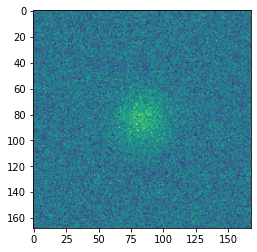

In [7]:
final = galsim.Convolve([gal, psf])
image = final.drawImage(scale=pixel_scale)
image.addNoise(galsim.GaussianNoise(sigma=noise))

plt.imshow(image.array)
plt.show()

# Convolution of the given PSF with a Gaussian Galsim Object (multiplication in Fourier Space)

In [8]:
gal_1 = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma).drawImage().array   
psf_img1 = galsim.Image(img1, copy=True).array      

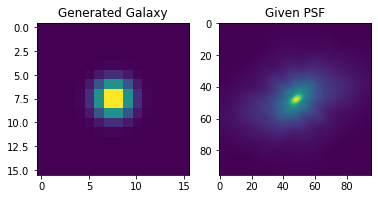

Dimensions - (16, 16) (96, 96)


In [9]:
plt.subplot(1,2,1)
plt.imshow(gal_1)
plt.title('Generated Galaxy')

plt.subplot(1,2,2)
plt.imshow(psf_img1)
plt.title('Given PSF')
plt.show()

m = gal_1.shape
n = psf_img1.shape
print('Dimensions -', m,n) 

### FFT with Padding

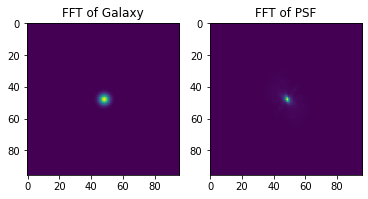

Dimensions - (96, 96) (96, 96)


In [10]:
gal_1_fft = np.pad(np.abs(fft.fftshift(fft.fft2(gal_1))), (abs(m[0]-n[0])//2, abs(m[1]-n[1])//2 ), 'constant')     
psf_img1_fft = np.abs(fft.fftshift(fft.fft2(psf_img1)))        # padded to match dimensions

plt.subplot(1,2,1)
plt.imshow(gal_1_fft)
plt.title('FFT of Galaxy')

plt.subplot(1,2,2)
plt.imshow(psf_img1_fft)
plt.title('FFT of PSF')
plt.show()

print('Dimensions -', gal_1_fft.shape, psf_img1_fft.shape)

### Convolution

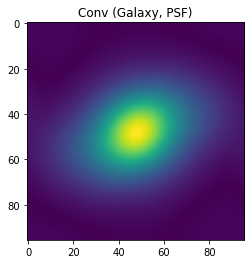

array([[558.45466047, 558.55431843, 558.83437517, ..., 559.23845649,
        558.83437517, 558.55431843],
       [557.29088574, 557.76629314, 558.41748463, ..., 556.83574904,
        556.8717668 , 557.00177535],
       [553.76941989, 554.71251258, 555.79889658, ..., 551.64809889,
        552.29005231, 552.97318383],
       ...,
       [547.80125375, 546.27793918, 544.79741878, ..., 552.81784436,
        551.08793523, 549.40443674],
       [553.76941989, 552.97318383, 552.29005231, ..., 556.98925705,
        555.79889658, 554.71251258],
       [557.29088574, 557.00177535, 556.8717668 , ..., 559.1971906 ,
        558.41748463, 557.76629314]])

In [11]:
conv1 = np.abs(fft.ifftshift(fft.ifft2(np.multiply(gal_1_fft, psf_img1_fft))))

plt.imshow(conv1)
plt.title('Conv (Galaxy, PSF)')
plt.show()
conv1

### Add Gaussian Noise

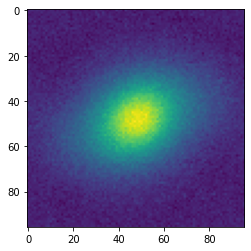

array([[-121.93678035, 1831.39125618, 2069.87712872, ..., -239.02116699,
        1146.46417993, 1123.2783525 ],
       [ 888.17653942,  624.14458258, -338.80719029, ..., 1277.19228587,
         497.39563987, 1995.00891365],
       [-948.13600803, -655.35870354,  435.51104524, ...,  390.12022427,
        1004.47562164, 1238.40372817],
       ...,
       [1505.15615011,  625.21877846, -170.13191991, ..., 1439.75650497,
        -942.94650718, 1218.42489728],
       [1997.62342706,  696.05147728,  198.63418695, ...,  -93.66069258,
         629.84917894,  581.56558954],
       [-279.10850772,  742.95594367, 1415.71798538, ...,  886.52305348,
         667.13905433, 1227.84187101]])

In [12]:
conv1_GSO = galsim.Image(conv1, copy=True)                      # Stored as GSO
conv1_GSO.addNoise(galsim.GaussianNoise(sigma=1e3))             # Gaussian Noise with std = 1e4
plt.imshow(conv1_GSO.array)
plt.show()
conv1_GSO.array

# Gradient Descent

In [13]:
iters = 100

# Original Implementation - https://waller-lab.github.io/DiffuserCam/tutorial/GD.html

def initMatrices(h):
    pixel_start = (np.max(h) + np.min(h))/2
    x = np.ones(h.shape)*pixel_start

    init_shape = h.shape
    padded_shape = [nextPow2(2*n - 1) for n in init_shape]
    starti = (padded_shape[0]- init_shape[0])//2
    endi = starti + init_shape[0]
    startj = (padded_shape[1]//2) - (init_shape[1]//2)
    endj = startj + init_shape[1]
    hpad = np.zeros(padded_shape)
    hpad[starti:endi, startj:endj] = h

    H = fft.fft2(fft.ifftshift(hpad), norm="ortho")
    Hadj = np.conj(H)

    def crop(X):
        return X[starti:endi, startj:endj]

    def pad(v):
        vpad = np.zeros(padded_shape).astype(np.complex64)
        vpad[starti:endi, startj:endj] = v
        return vpad

    utils = [crop, pad]
    v = np.real(pad(x))
    
    return H, Hadj, v, utils

def nextPow2(n):
    return int(2**np.ceil(np.log2(n)))

In [14]:
def grad(Hadj, H, vk, b, crop, pad):
    Av = calcA(H, vk, crop)
    diff = Av - b
    return np.real(calcAHerm(Hadj, diff, pad))

In [15]:
def calcA(H, vk, crop):
    Vk = fft.fft2(fft.ifftshift(vk))
    return crop(fft.fftshift(fft.ifft2(H*Vk)))

In [16]:
def calcAHerm(Hadj, diff, pad):
    xpad = pad(diff)
    X = fft.fft2(fft.ifftshift(xpad))
    return fft.fftshift(fft.ifft2(Hadj*X))

In [17]:
def grad_descent(h, b):
    H, Hadj, v, utils = initMatrices(h)
    crop = utils[0]
    pad = utils[1]
        
    alpha = np.real(1.8/(np.max(Hadj * H)))
    iterations = 0
     
    def non_neg(xi):
        xi = np.maximum(xi,0)
        return xi
    
    #proj = lambda x:x  # Do no projection
    proj = non_neg      # Enforce nonnegativity at every gradient step. Comment out as needed.


    parent_var = [H, Hadj, b, crop, pad, alpha, proj]
    
    vk = v     
    
    #### uncomment for FISTA update ################
    tk = 1
    xk = v
    ################################################
        
    for iterations in range(iters):   
        
        # uncomment for regular GD update
        #vk = gd_update(vk, parent_var)    
        
        # uncomment for FISTA update
        vk, tk, xk = fista_update(vk, tk, xk, parent_var)

        if iterations % 10 == 0:
            image = proj(crop(vk))
            f = plt.figure(1)
            plt.imshow(image)
            plt.title('Reconstruction after iteration {}'.format(iterations))
            plt.show(f)    
    
    return proj(crop(vk)) 

In [18]:
def gd_update(vk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    vk = proj(vk)
    
    return vk    

### FISTA Update

In [19]:
def fista_update(vk, tk, xk, parent_var):
    H, Hadj, b, crop, pad, alpha, proj = parent_var
    
    x_k1 = xk
    gradient = grad(Hadj, H, vk, b, crop, pad)
    vk -= alpha*gradient
    xk = proj(vk)
    t_k1 = (1+np.sqrt(1+4*tk**2))/2
    vk = xk+(tk-1)/t_k1*(xk - x_k1)
    tk = t_k1
    
    return vk, tk, xk

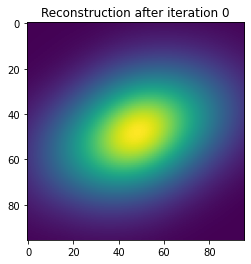

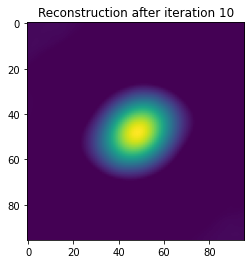

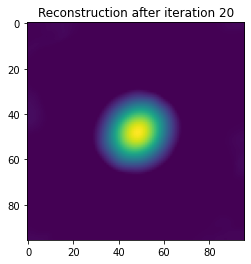

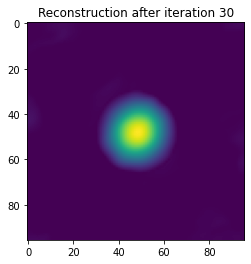

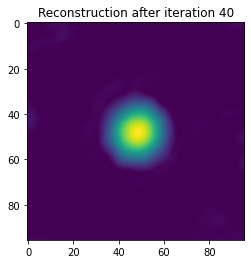

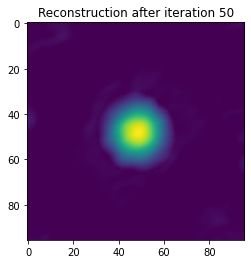

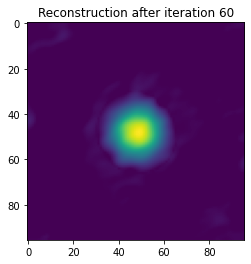

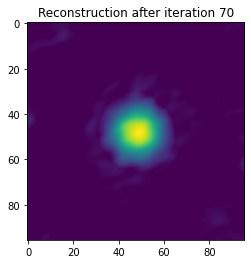

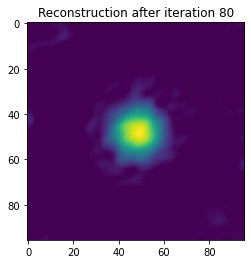

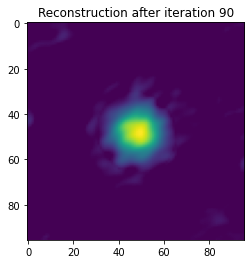

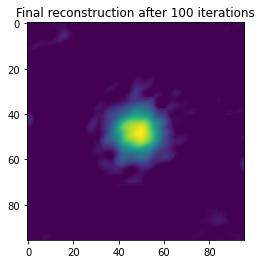

In [20]:
final_im = grad_descent(psf_img1, conv1_GSO.array)
plt.imshow(final_im)
plt.title('Final reconstruction after {} iterations'.format(iters))
plt.show()